#Text Data Analysis Notebook
Book Rating Predictor <br>
Sabrina Ruiz

# Introduction
In this notebook, I will optimize the text vectorization and processing for the `review` column of my cleaned data. I will create a custom tokenizer to best fit my data set. Lastly, I will create a prediction model that will predict a book's review score based on users' written reviews.

#### ***Why predict the book review rating?***
Ultimately, I plan to productionalize this project for my current workplace, an elementary school. I plan to create a system in which a child can input their review of a book they liked, and get a selection of books to read next.

# Set Up

In [114]:
# basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os

from numpy import mean, std

import warnings
warnings.filterwarnings('ignore')

In [143]:
#preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import string
import nltk

import re
stemmer = nltk.stem.PorterStemmer()
from nltk.stem import WordNetLemmatizer

# import the nltk things
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

# modelling and related ml libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score



# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # this would be for binary predictor, didn't use

import pickle


#PyTorch | BERT libraries
import tensorflow as tf
from transformers import AutoTokenizer, BertTokenizer, DistilBertTokenizerFast
from transformers import BertModel, TFBertModel #BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, SGD, AdamW
from torch.nn import Parameter



# libraries that I thought I would use but ultimately didn't
    #from sklearn.compose import ColumnTransformer
    #from imblearn.under_sampling import RandomUnderSampler
    #from sklearn.metrics.pairwise import cosine_similarity


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [87]:
# NOTEBOOK FORMAT STANDARDS
np.random.seed(18)

# setting a color palette for Seaborn visualizations
bright_palette = sns.set_palette(palette = "bright")

#other visual standards
plt.rcParams['figure.figsize'] = (10,3) #mainly word count graphs
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [5]:
# GOOGLE COLAB DRIVE CONNECTION
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#force_remount=True, for file update

Mounted at /content/drive


In [ ]:
# os.listdir('/content/drive/My Drive/Brainstation/data/')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Brainstation/data/'

In [88]:
# LOAD EDA NTBK CLEANED DATA (From colab)
data = pd.read_csv('/content/drive/My Drive/Brainstation/data/combined_book_data_cut.csv', index_col=0)
data.head() # takes about 60 secs

,Id,Title,User_id,profileName,review_score,review_summary,review,authors,publishedDate,categories
0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",4,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,Julie Strain,1996.0,Comics & Graphic Novels
1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,Kevin Killian,5,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,Philip Nel,2005.0,Biography & Autobiography
2,0826414346,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,John Granger,5,Essential for every personal and Public Library,"If people become the books they read and if ""t...",Philip Nel,2005.0,Biography & Autobiography
3,0826414346,Dr. Seuss: American Icon,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",4,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",Philip Nel,2005.0,Biography & Autobiography
4,0826414346,Dr. Seuss: American Icon,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",4,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,Philip Nel,2005.0,Biography & Autobiography


In [ ]:
data.shape

(2616533, 10)

# Exploring Sentiment
for the purposes of exploring general sentiment, I will convert the `review_score` to a binary representing *positive* and *negative* sentiment. Next, I will explore the possibility of a multiclass classifier. A multiclass system would perhaps addresess any issues brought about with a simple binary.

For the purpose of this project, I will set ***negative*** sentiment to be scores of 3 and below, and ***positive*** sentiment to be scores 4 & 5. Ultimately, I wish to train my final book recommender model on elementary school book data for children to use. In my experience, children tend to be more polar in their likes and dislikes.

#### "Positive" & "Negative" Sentiment

In [ ]:
#creating a new df, binary sentiment
pos_neg_df = data.copy()
pos_neg_df.head(2)

,Id,Title,User_id,profileName,review_score,review_summary,review,authors,publishedDate,categories
0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",4,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,Julie Strain,1996.0,Comics & Graphic Novels
1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,Kevin Killian,5,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,Philip Nel,2005.0,Biography & Autobiography


In [ ]:

pos_neg_df['review_score'] = np.where(pos_neg_df['review_score'] > 3, 1, 0)
# change column name to reflect changes
pos_neg_df.rename(columns={"review_score": "sentiment"}, inplace=True)
pos_neg_df.head()

,Id,Title,User_id,profileName,sentiment,review_summary,review,authors,publishedDate,categories
0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",1,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,Julie Strain,1996.0,Comics & Graphic Novels
1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,Kevin Killian,1,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,Philip Nel,2005.0,Biography & Autobiography
2,0826414346,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,John Granger,1,Essential for every personal and Public Library,"If people become the books they read and if ""t...",Philip Nel,2005.0,Biography & Autobiography
3,0826414346,Dr. Seuss: American Icon,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",1,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",Philip Nel,2005.0,Biography & Autobiography
4,0826414346,Dr. Seuss: American Icon,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",1,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,Philip Nel,2005.0,Biography & Autobiography


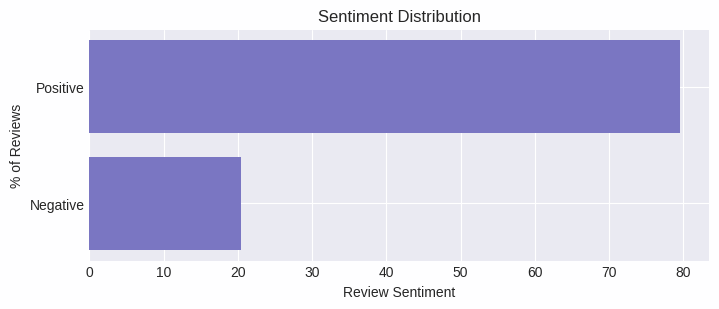

Class imbalance: [0.2 0.8]


In [ ]:
values, counts = np.unique(pos_neg_df['sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure(figsize=(8, 3))
plt.title("Sentiment Distribution")
plt.barh(["Negative", "Positive"], normalized_counts*100) # plot normalized counts
plt.xlabel('Review Sentiment')
plt.ylabel('% of Reviews')
plt.show()

print(f"Class imbalance: {np.round(normalized_counts, 2)}")

This is quite inbalanced! To be more precise, [Google](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data) would classify this as a "moderate" degree of imbalance.
#### MultiClass Sentiment
Let's explore having a three-class division of sentiment, with a score of 3 being "neutral."

In [ ]:
#create new df for 3 classes
three_class_df = data.copy()
#divide rating to 3
three_class_df['sentiment'] = np.select([three_class_df['review_score'] == 1,
                                         three_class_df['review_score'] == 2,
                                         three_class_df['review_score'] == 3,
                                         three_class_df['review_score'] == 4,
                                         three_class_df['review_score'] == 5],
                                          [0,0,1,1,2], default=np.nan)
three_class_df

,Unnamed: 0,Id,Title,User_id,profileName,review_score,review_summary,review,authors,publishedDate,categories,sentiment
0,0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",4,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,Julie Strain,1996.0,Comics & Graphic Novels,1.0
1,1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,Kevin Killian,5,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,Philip Nel,2005.0,Biography & Autobiography,2.0
2,2,0826414346,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,John Granger,5,Essential for every personal and Public Library,"If people become the books they read and if ""t...",Philip Nel,2005.0,Biography & Autobiography,2.0
3,3,0826414346,Dr. Seuss: American Icon,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",4,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",Philip Nel,2005.0,Biography & Autobiography,1.0
4,4,0826414346,Dr. Seuss: American Icon,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",4,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,Philip Nel,2005.0,Biography & Autobiography,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2974297,2999787,B000NSLVCU,The Idea of History,unknown,unknown,4,Difficult,"This is an extremely difficult book to digest,...",R. G. Collingwood,2018.0,History,1.0
2974298,2999788,B000NSLVCU,The Idea of History,A1SMUB9ASL5L9Y,jafrank,4,Quite good and ahead of its time occasionally,This is pretty interesting. Collingwood seems ...,R. G. Collingwood,2018.0,History,1.0
2974299,2999789,B000NSLVCU,The Idea of History,A2AQMEKZKK5EE4,"L. L. Poulos ""Muslim Mom""",4,Easier reads of those not well versed in histo...,"This is a good book but very esoteric. ""What i...",R. G. Collingwood,2018.0,History,1.0
2974300,2999790,B000NSLVCU,The Idea of History,A18SQGYBKS852K,"Julia A. Klein ""knitting rat""",5,"Yes, it is cheaper than the University Bookstore","My daughter, a freshman at Indiana University,...",R. G. Collingwood,2018.0,History,2.0


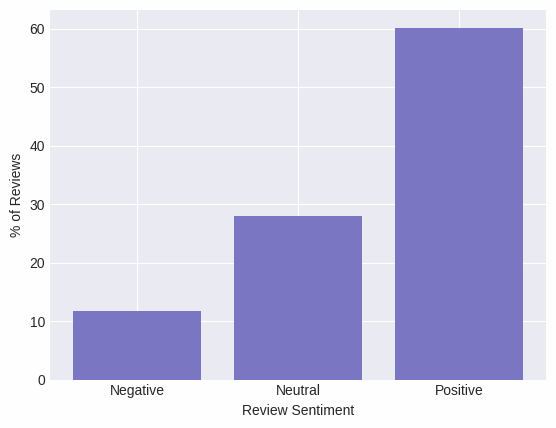

Class imbalance: [0.12 0.28 0.6 ]


In [ ]:
values, counts = np.unique(three_class_df['sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(["Negative", "Neutral","Positive"], normalized_counts*100) # plot normalized counts
plt.xlabel('Review Sentiment')
plt.ylabel('% of Reviews')
plt.show()

print(f"Class imbalance: {np.round(normalized_counts, 2)}")

This is still pretty biased, and not an accurate division between the three classifications.

Refer to the appendix for steps taken to address this inbalance.  

# Preprocessing

For the sake of processing power, only a sample of the data as shown in the code below, will be selected. This number was increased as much as possible using Google Colab's CPU. Seeing as my terminal shuts down as soon as each Vectorizer is completed, I will elect to save the `review` column's preprocessing as a CSV for efficiency.

In [97]:
#Which is my current  working dataframe?
modeling_df = data.sample(n=100000, random_state=18)
modeling_df

,Id,Title,User_id,profileName,review_score,review_summary,review,authors,publishedDate,categories
2476676,096406054X,Mouse Tales: A Behind-the-Ears Look at Disneyl...,A89Y6WZKEP069,Jewelz- Theo's Mom,2,Caution: You may lose a bit of the magic....,This is a very well written book about the inn...,David Koenig,2005.0,Biography & Autobiography
2941482,B000MC7FBS,WAR AS I KNEW IT.,A3KFFGZCE3R836,Steven Patton,5,War as I knew it.,Fantastic! Wish we had a leader such as him to...,George Smith Patton,1980.0,Generals
141151,B000KIT9U4,The Shelters Of Stone - The Earth's Children S...,A5XSPTAK24CDZ,HannahR,1,Puh-leese...,"...hindsight being 20/20, I would have wished ...",Jean M. Auel,2002.0,Fiction
2153415,B000KAFUP0,The Clear and Simple Thesaurus Dictionary,AFHYEO3Y1IIDD,maximum verbosity,5,"Different than expected, but still happy",I thought this book was for a little bit young...,"Harriet Wittels', 'Joan Greisman",2006.0,Juvenile Nonfiction
2853977,1590591518,Learn to Program with Visual Basic 6,A12KQ3ZZO00ZBX,K. Schaller,4,Effective teaching technique,Mr. Smiley uses the approach of solving real-w...,John Smiley,2003.0,uncategorized
...,...,...,...,...,...,...,...,...,...,...
2173289,1413715230,"Sunny, Ward of the State: Calamity Strikes a F...",A1X0J509VGPTKA,SwitzerlandBob,5,This book brought back memories for my Dad,My Dad Bob Richartz grew up at Leake & Watts i...,Sonja Heinze Coryat,2004.0,uncategorized
1677085,0786282029,S Is For Silence,AGJR0N9LE9MYU,Vidagray,5,"""S"" is for Silence",Sue Grafton writes a good mystery. I love them...,Sue Grafton,2009.0,Fiction
871374,B0006E2W9M,The grapes of wrath (The Collector's library o...,unknown,unknown,5,"Get off Steinbeck, he's the the man, ...",The Grapes of Wrath was a great book filled wi...,Library of Congress,1981.0,Monographic series
2461625,1570424713,Selling the Invisible: A Field Guide to Modern...,AFUSHCALNDGJJ,"Leonard ""Leonard""",5,"An unassuming charming book, I loved it!",I started reading it and couldn't put it down....,Harry Beckwith,2000.0,Business & Economics


In [98]:
X = modeling_df[['Title','User_id', 'review']]
y = modeling_df['review_score']

In [80]:
modeling_df_modified = data_with_clean_text_col.sample(n=10000, random_state=18)
modeling_df_modified.head(2)

NameError: name 'data_with_clean_text_col' is not defined

In [99]:
X = modeling_df_modified[['Title','User_id', 'clean_review']]
y = modeling_df_modified['review_score']

NameError: name 'modeling_df_modified' is not defined

In [100]:
# splitting our data into train and test sets
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.33, random_state=18, stratify=y)
# 10 secs
# split train into train validation sets
X_train, X_val, y_train, y_val = train_test_split(X_remainder, y_remainder, test_size=0.3, random_state=18)

In [ ]:
X_train.head(2)

,Title,User_id,clean_review
2581705,Owl Babies (Turtleback School & Library Bindin...,A55N8FQKPV7OW,funny little poor little bill clearly littlest...
1666935,Desire Never Dies (Lady Spies),A1AKQ1YUS4BT82,first chapter hooked continued slowly lost int...
1122302,Vom Winde Verweht ( Gone With the Wind ),AQ1VC36EGABK5,love well known beautiful want great romance w...
2439415,Lockout: Why America Keeps Getting Immigration...,A2MB8VQSTCA7M0,michele wucker show u yet analyze complicated ...
836595,Abandoned Prayer,A1WIB83YCTO2R4,avid reader true crime boring almost gave many...
...,...,...,...
2982527,Dry: A Memoir,unknown,run buy minute finished quotrunning scissorsqu...
1335314,Lydia Cassatt Reading the Morning Paper,A1AB7XM279L10G,artist especially enjoyed description process ...
667809,Red Tent,APIBA50XRYCUH,one among thousandthe well written qualm femal...
2658559,The Lord of the Rings Trilogy 3 Volumes,A2P7YA6JMPBIIT,man best ever written worldyou hear older stil...


In [82]:
print("The train-test variable shapes:")
print("X_train:",X_train.shape)
print("x_val:",X_val.shape)
print("X_test:",X_test.shape)
print(" ")
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("y_test:", y_test.shape)


The train-test variable shapes:
X_train: (469000, 3)
x_val: (201000, 3)
X_test: (330000, 3)
 
y_train: (469000,)
y_val: (201000,)
y_test: (330000,)


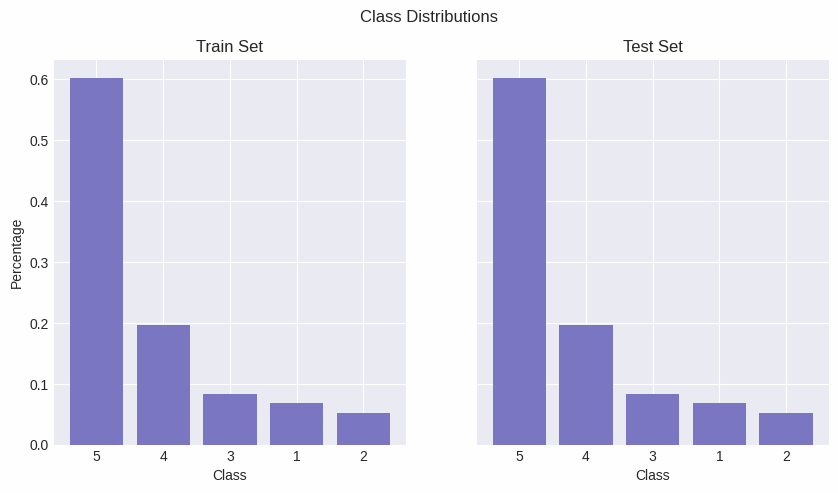

In [ ]:
# Get the value counts of our train and test sets
y_train_vals = y_train.value_counts()
y_test_vals = y_test.value_counts()

# Plot the distributions to check if they match the original
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax1.bar(y_train_vals.index.astype(str), y_train_vals.values/sum(y_train_vals.values))
ax2.bar(y_test_vals.index.astype(str), y_test_vals.values/sum(y_test_vals.values))
plt.suptitle("Class Distributions")
ax1.set_title("Train Set")
ax1.set_xlabel("Class")
ax1.set_ylabel("Percentage")
ax2.set_title("Test Set")
ax2.set_xlabel("Class")
plt.show()

This ensured that the train-test split maintained the same distribution as the original dataset.

#### Building a Custom Tokenizer

Next, I will attempt to create a custom tokenizer to best fit and optimize the model. This will be the baseline results for my model later on.

In [92]:
#words aside from stop words to ignore
MY_STOP_WORDS = stopwords.words('english')
GENERIC_WORDS = ["book" , "author" , "read" , "character" , "story" , "page" , "write" , "series" , "review"]
MY_STOP_WORDS.extend(GENERIC_WORDS)

def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []

    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in MY_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

In [ ]:
# run if check needed
# MY_STOP_WORDS

In [ ]:
# sanity check
sentence = "Can you believe that: his (dog) like, read my book!"
my_tokenizer(sentence)

['believ', 'dog', 'like']

The words on my added stop list seem to be removed as well! This seems like a good start. I will put this tokenizer to the test.

In [ ]:
custom_cv = CountVectorizer(min_df =5,
                            max_features= 1000,
                            tokenizer=my_tokenizer)
custom_cv.fit(X_train['review'])

X_train_custom_transformed = custom_cv.transform(X_train['review'])
X_test_custom_transformed = custom_cv.transform(X_test['review'])

X_train_custom_transformed.shape

(15000, 1000)

In [ ]:
X_train_custom_transformed

<10x10 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

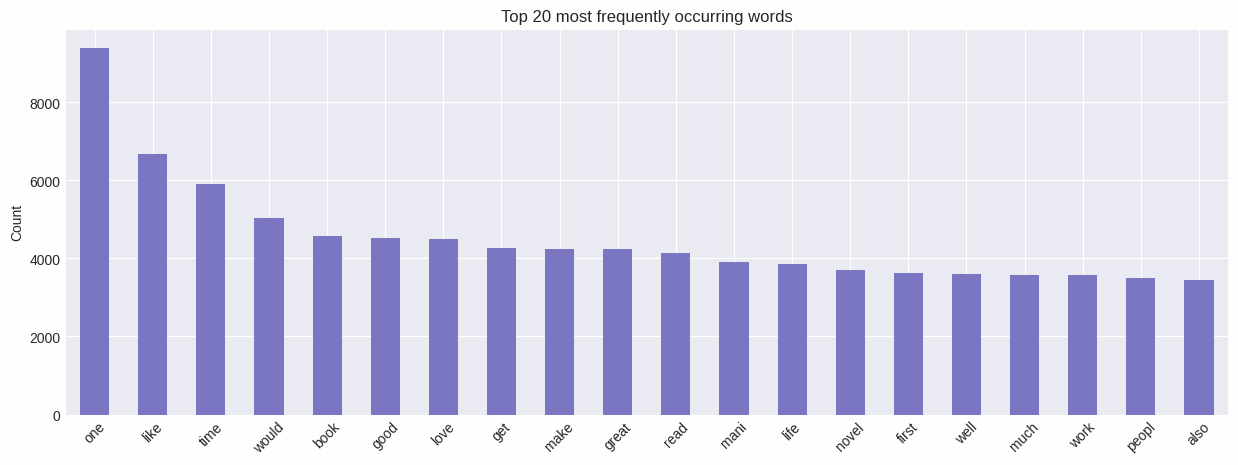

In [ ]:
word_counts = pd.DataFrame(
    {"counts": X_train_custom_transformed.toarray().sum(axis=0)},
    index=custom_cv.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

#### TF-IDF

In [93]:
tfidf = TfidfVectorizer(min_df =2,
                        max_features=1000,
                        tokenizer=my_tokenizer
                        )
X_train_transformed_tfidf = tfidf.fit_transform (X_train.review)
X_val_transformed_tfidf = tfidf.transform(X_val.review)
X_test_transformed_tfidf = tfidf.transform(X_test.review)

X_train_transformed_tfidf.shape
#cell takes 10 mins
# 50,000 = 5 mins
# 1mil = 30 mins



(23450, 1000)

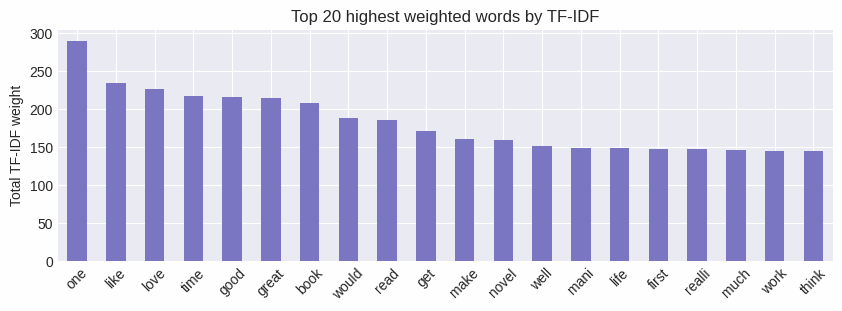

In [ ]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed_tfidf.toarray().sum(axis=0)},
    index=tfidf.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(10, 3), legend=False)
plt.title("Top 20 highest weighted words by TF-IDF")
plt.ylabel("Total TF-IDF weight")
plt.xticks(rotation=45)
plt.show()

In [101]:
#100 000 sample
tfidf_hundred = TfidfVectorizer(min_df =2,
                        max_features=1000,
                        tokenizer=my_tokenizer
                        )
X_train_transformed_hundred = tfidf_hundred.fit_transform (X_train.review)
X_val_transformed_hundred = tfidf_hundred.transform(X_val.review)
X_test_transformed_hundred = tfidf_hundred.transform(X_test.review)

X_train_transformed_hundred.shape
#cell takes 10 mins
# 50,000 = 5 mins
# 1mil = 30 mins

(46900, 1000)

In [ ]:
print(tfidf.get_feature_names_out()[800:900])


['share' 'she' 'ship' 'short' 'show' 'side' 'similar' 'simpl' 'simpli'
 'sinc' 'singl' 'sister' 'sit' 'situat' 'skill' 'slow' 'small' 'social'
 'societi' 'someon' 'someth' 'sometim' 'somewhat' 'son' 'soon' 'sort'
 'soul' 'sound' 'sourc' 'south' 'space' 'speak' 'special' 'specif' 'spend'
 'spent' 'spirit' 'spiritu' 'stand' 'standard' 'star' 'start' 'state'
 'stay' 'step' 'still' 'stop' 'stori' 'strang' 'strength' 'strong'
 'structur' 'struggl' 'student' 'studi' 'stuff' 'style' 'subject'
 'success' 'suffer' 'suggest' 'support' 'suppos' 'sure' 'surpris' 'surviv'
 'suspens' 'symbol' 'system' 'take' 'taken' 'tale' 'talent' 'talk' 'teach'
 'teacher' 'team' 'techniqu' 'technolog' 'teenag' 'tell' 'ten' 'term'
 'terribl' 'test' 'text' 'thank' 'that' 'theme' 'theori' 'there' 'thing'
 'think' 'third' 'though' 'thought' 'three' 'throughout' 'thu' 'time']


# Modeling
I have tested the TF-IDF results through various models learned. Please refer to the appendix for all models tested. <br>

**My process:**<br>
After running mulitple different models (LogReg, KNN, Decision Tree, BERT/Pytorch) with minimal parameter tuning, I chose to continue hypertuning the model `log_reg_final_model_large`. This one shown below yielded the best results in terms of score and not-overfitting.

In [96]:
#50 000 sample
# Fitting a model
logreg_param_added= LogisticRegression(C=5e1,
                                  solver='lbfgs',
                                  multi_class='multinomial',
                                  random_state=18,
                                  n_jobs=-1)
logreg_param_added.fit(X_train_transformed_tfidf, y_train)

# Training and test score
print(f"Train score: {logreg_param_added.score(X_train_transformed_tfidf, y_train)}")
print(f"Test score: {logreg_param_added.score(X_val_transformed_tfidf, y_val)}")
pickle.dump(logreg_param_added,open('/content/drive/My Drive/Brainstation/models/log_reg_final_model', 'wb'))
#parameters chosen per this notebook https://www.kaggle.com/code/kashnitsky/logistic-regression-tf-idf-baseline

Train score: 0.6825586353944563
Test score: 0.6188059701492538


shows signs of overfitting

In [102]:
#100 000 sample
logreg_param_added_hundred= LogisticRegression(C=5e1,
                                  solver='lbfgs',
                                  multi_class='multinomial',
                                  random_state=18,
                                  n_jobs=-1)
logreg_param_added_hundred.fit(X_train_transformed_hundred, y_train)

# Training and test score
print(f"Train score: {logreg_param_added_hundred.score(X_train_transformed_hundred, y_train)}")
print(f"Test score: {logreg_param_added_hundred.score(X_val_transformed_hundred, y_val)}")
pickle.dump(logreg_param_added_hundred,open('/content/drive/My Drive/Brainstation/models/log_reg_final_model_large', 'wb'))
#parameters chosen per this notebook https://www.kaggle.com/code/kashnitsky/logistic-regression-tf-idf-baseline

Train score: 0.6678464818763327
Test score: 0.6383582089552239


with a bigger sample, the gap between the scores is less noticeable! However, this is the biggest sample size my machine can tokenize, and thus I will have to be satisfied with this model as my final one.

#Model Analysis
First, I will run all my models through a prediction function, then I will evaluate the results. I chose to use the F1 score to measure my model because

In [103]:
final_model = pickle.load(open('/content/drive/My Drive/Brainstation/models/log_reg_final_model_large', 'rb'))
final_model

LogisticRegression(C=50.0, multi_class='multinomial', n_jobs=-1,
                   random_state=18)

In [107]:
# testing pickle was saved correctly
print(f"Train score: {final_model.score(X_train_transformed_hundred, y_train)}")
print(f"Test score: {final_model.score(X_val_transformed_hundred, y_val)}")

Train score: 0.6678464818763327
Test score: 0.6383582089552239


In [115]:
n_scores = cross_val_score(final_model, X_test_transformed_hundred, y_test, scoring='accuracy', n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.627 (0.003)


In [120]:
y_pred_hundred = final_model.predict(X_test_transformed_hundred)
print('Predicted Class: %d' %y_pred_hundred[0])

Predicted Class: 5


In [123]:
# Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_hundred, average=None)
recall = recall_score(y_test, y_pred_hundred, average=None)
f1 = f1_score(y_test, y_pred_hundred, average=None)

# Print precision, recall, and F1-score for each class
#for i in range(len(precision)):
 #   print("Class:", i)
  #  print("Precision:", precision[i])
   # print("Recall:", recall[i])
    #print("F1-score:", f1[i])

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_hundred))

Classification Report:
              precision    recall  f1-score   support

           1       0.48      0.39      0.43      2233
           2       0.27      0.14      0.18      1690
           3       0.33      0.19      0.24      2758
           4       0.40      0.19      0.26      6465
           5       0.71      0.92      0.80     19854

    accuracy                           0.64     33000
   macro avg       0.44      0.36      0.38     33000
weighted avg       0.58      0.64      0.59     33000



From the results above, you can see that ultimately, my model did not do a very good job of predicting any of the ratings aside from 5. As even more evident in the "support" column, this is most likely due to the skewed number of 5-star ratings. To improve this model in the future, the first step will definetely be to address that data inbalance.

That aside, the model generally has better precision than recall, except for ratings of `5`. The f1-score is highest for `5` and `1`, which again goes back to ratings count.  

# Next Steps & "Productionalization"
If I were to further improve this model (aside from addressing the data  inbalance), I would try and use all the data available to me via higher computing power. Also, to formally use this model as a product, the next step would be to "productionalize." In a future notebook, I will outline steps to create a simple web service for use.

Below I have created a basic, fun predictor function that inputs a string of text, and outputs the predicted score.


In [138]:
def predict_rating(text):

    # Preprocess the text
    text_transformed = tfidf_hundred.transform([text])

    # Predict the rating score
    predicted_score = final_model.predict(text_transformed)

    print(f'I think you would rate this book a {predicted_score[0]}!')

In [137]:
predict_rating("this is the best book in the whole world!")

"I think you would rate this book a 5!


In [139]:
predict_rating("this is the worst book in the whole world!")

I think you would rate this book a 1!


The examples above are pretty clear cut. Let me try a more neutral statement.

In [141]:
predict_rating("This is the third Sherlock book by Conan Doyle. It's nothing like the show.")

I think you would rate this book a 2!


# Appendix
Below I outline additional methods I utilized over the course of this project.



#### Addressing Data Inbalance

I will take the following steps to address the data inbalance:


1.   **Do nothing:** I will see if the imbalance affects results. If issues arise, I will move on to step 2.
2.   **Undersampling** I will attempt removing reviews of the majority class, "positive sentiment." Seeing as this is a large dataset, for the sake of computing power and efficiency, I decided "oversampling" would be less ideal.

Any steps taken will be during or after the train-test split so as to have the test data remain as real as possible.



#### Bag of Words Vectorizer
I will put my dataset through various versions of a CountVectorizer to see which yields the best results. First, I will start off with a standard one of simple English stop words and max the features at 1000.

In [ ]:
working_cv = CountVectorizer(stop_words=MY_STOP_WORDS, min_df=10, max_features=1000)
working_cv.fit(X_train['review'])
X_train_transformed = working_cv.transform(X_train['review'])
X_test_transformed = working_cv.transform(X_test['review'])
X_test_transformed.shape
#cell takes 12 mins

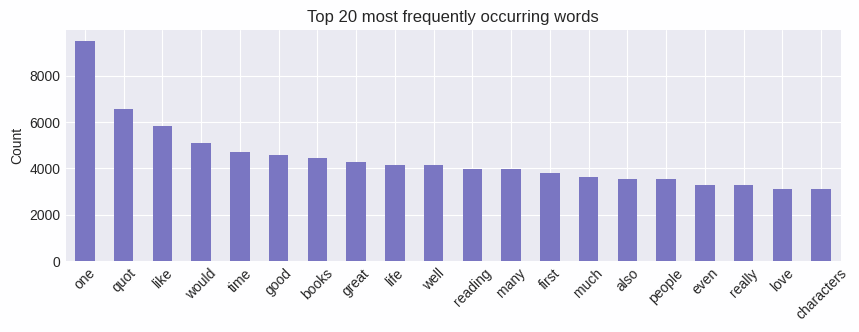

In [ ]:
#visualizing most common  wds

word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=working_cv.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(10,3), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.show()

In [ ]:
# Fitting a model
logreg = LogisticRegression(C = 0.1)
logreg.fit(X_train_transformed, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train_transformed, y_train)}")
print(f"Test score: {logreg.score(X_test_transformed, y_test)}")

Train score: 0.6956
Test score: 0.6158


Although 65% may seem low, this is simply a baseline score. There was no hyperoptimization or customization done. From the simple logistic regression, here is a viualization of the top words with positive sentiment:

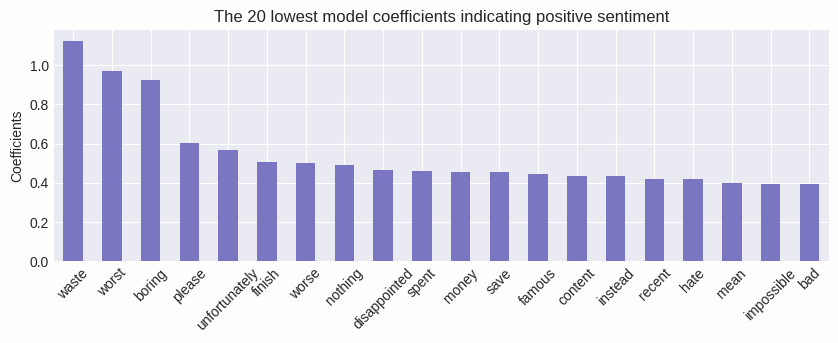

In [ ]:
word_counts.sort_values("coefficients", ascending=False).head(20).plot(kind="bar", figsize=(10,3), legend=False)
plt.title("The 20 lowest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

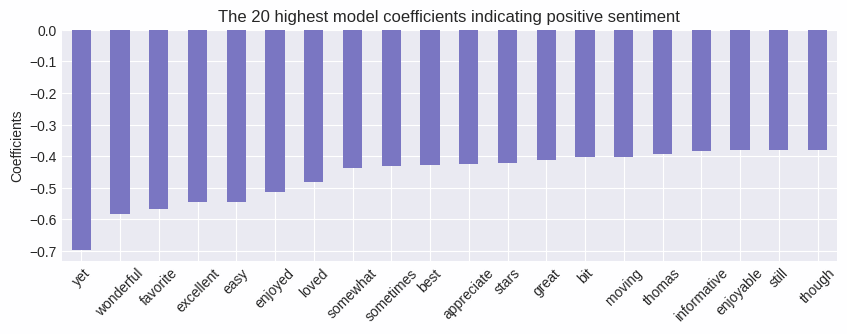

In [ ]:
#visualizing positive sentiment
word_counts = pd.DataFrame(
    {"coefficients": logreg.coef_[0]},
    index=working_cv.get_feature_names_out()
).sort_values("coefficients", ascending=True)

word_counts.head(20).plot(kind="bar", figsize=(10,3), legend=False)
plt.title("The 20 highest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()


It seems that in this case, negative coefficients seem to have positive connotations, and vice versa for positive coefficients.

## Text Classification with BERT
Sources

## Preprocessing Pt 2 (for BERT input)

To make the process run smoothly, I will preprocess the data, save it to a csv, then recall that data as needed.

**Creating Cleaned Text DataFrame**

In [ ]:
# preparing "review" text column for tokenizing (aka add cleaned text only column)
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Remove digits
    text = re.sub("\d+", " ", text)

    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)

    # Lowercase the text
    text = text.lower()

    # Remove stop words
    stop_words = MY_STOP_WORDS
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words)

    return text
# this cleaning function found at https://www.kaggle.com/code/ahmedmoharm/sentiment-analysis-bert-pytorch

In [ ]:
data_with_clean_text_col = data[['Title','User_id', 'review', 'review_score']]

In [ ]:
data_with_clean_text_col.shape


(2616533, 4)

In [ ]:
data_with_clean_text_col['clean_review'] = data_with_clean_text_col['review'].apply(lambda i: clean_text(i))

In [ ]:
data_with_clean_text_col.head()

,Title,User_id,review,review_score,clean_review
0,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,This is only for Julie Strain fans. It's a col...,4,julie strain fan collection photo page worth n...
1,Dr. Seuss: American Icon,A30TK6U7DNS82R,I don't care much for Dr. Seuss but after read...,5,dont care much dr seuss reading philip nels ch...
2,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,"If people become the books they read and if ""t...",5,people become book child father man dr seuss t...
3,Dr. Seuss: American Icon,A2MVUWT453QH61,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",4,theodore seuss geisel aka quotdr seussquot one...
4,Dr. Seuss: American Icon,A22X4XUPKF66MR,Philip Nel - Dr. Seuss: American IconThis is b...,4,philip nel dr seuss american iconthis basicall...


In [ ]:
#export tokenized df, this will be the new working df
data_with_clean_text_col.to_csv('clean_text_complete.csv')
!cp clean_text_complete.csv "/content/drive/My Drive/"

# LOAD DATA BACK IN? See set up section at top, dataframe with same name

In [ ]:
# LOAD CLEANED TEXT REVIEW DF (SEE #BERT V2 FOR PROCESS)
data_with_clean_text_col = pd.read_csv('/content/drive/My Drive/Brainstation/data/clean_text_complete_idk.csv', index_col=0)
data_with_clean_text_col.head() # takes about 60 secs

**1. Define Dataset & Model**


In [ ]:
# Set up the GPU for COLAB & model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Set up parameters
bert_model_name = 'distilbert-base-uncased'
num_classes = len(modeling_df_modified['review_score'].unique()) # number of unique labels for our multi-class classification problem
output_attentions = False,
max_length = 500
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

In [ ]:
#tokenizer = DistilBertTokenizerFast.from_pretrained(bert_model_name)

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    bert_model_name,
    num_labels = num_classes,
    output_hidden_states = False,
)
model.to(device)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['encoder.layer.4.attention.self.query.weight', 'encoder.layer.5.attention.self.key.weight', 'encoder.layer.1.output.dense.weight', 'encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.6.attention.self.key.weight', 'encoder.layer.3.attention.output.dense.bias', 'encoder.layer.9.attention.output.LayerNorm.weight', 'encoder.layer.10.attention.self.key.weight', 'encoder.layer.10.attention.self.value.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.5.intermediate.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.11.attention.output.LayerNorm.weight', 'encoder.layer.3.output.LayerNorm.bias', 'encoder.layer.11.

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# splitting data into training-test-validation sets as opposed to variables
other_df, test_df = train_test_split(modeling_df_modified, test_size=0.33, random_state=18, stratify=y)
test_df = test_df.reset_index(drop=True)

#add validating set
train_df, val_df = train_test_split(other_df, test_size=0.3, random_state=18)

In [ ]:
train_df.head(1)

,Title,User_id,review,review_score,clean_review
2344978,Master Class,unknown,Let history books decide if Callas was this or...,5,let history book decide calla mcnallys play at...


In [ ]:
# this dataset class organizes the df for input to BERT model
class ClassificationDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.texts = df['clean_review'].tolist()
        self.labels = df['review_score'].tolist()
        self.tokenizer = DistilBertTokenizerFast.from_pretrained(bert_model_name)
        self.max_length = 500

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
      text = self.texts[index], # text=review/input,
      label = self.labels[index]

      encoding = self.tokenizer(
            text,
            return_tensors= 'pt', #returns tokenized data as pytorch tensors
            max_length= self.max_length,
            padding='max_length',
            return_attention_mask=True,
            truncation=True
        )

      return {'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label)}


In [ ]:
#testing that class outputs w no errors
testing_dataset_class = ClassificationDataset(train_df)

**2. Create Dataloaders**

In [ ]:

train_set = ClassificationDataset(train_df)
val_set = ClassificationDataset(val_df)
test_set = ClassificationDataset(test_df)
###########################################################

In [ ]:
print("No. of reviews in datasets:")
print("train set: {}".format(len(train_set)))
print("val set: {}".format(len(val_set)))
print("test set: {}".format(len(test_set)))
#check to see if output matches original length, as of this print, it does!

No. of reviews in datasets:
train set: 4690
val set: 2010
test set: 3300


In [ ]:
#Create Data loaders
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader =  DataLoader(test_set, batch_size=batch_size, shuffle=False)

**3. Fine-tuning a Model**<br>

The following steps will be taken to further develop the model:
*   define an optimizer
*   define an accuracy/evaluation methods
  *   set up validation

In [ ]:
# get score distribution and weights for crossEntropyLoss parameters
score_counts = modeling_df_modified.groupby('review_score')
#DISTRIBUTION
score_distribution = []
for i in range(num_classes):
    score_distribution.append(len(score_counts.groups[i+1])/len(modeling_df_modified))

score_distribution = torch.tensor(score_distribution, dtype=torch.float32)

# WEIGHTS
weights = 1.0 / score_distribution
weights = weights / weights.sum()


print('{:<20}: {}'.format('Score distribution', score_distribution.tolist()))
print('{:<20}: {}'.format('Weights', weights.tolist()))

Score distribution  : [0.06920000165700912, 0.051500000059604645, 0.07829999923706055, 0.1979999989271164, 0.6029999852180481]
Weights             : [0.27087610960006714, 0.36397337913513184, 0.23939499258995056, 0.09466984122991562, 0.03108561784029007]


In [ ]:
# Define the optimizer
loss_function = torch.nn.CrossEntropyLoss(weight=weights.to(device), reduction='mean')
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [ ]:
#define accuracy function
def calculate_accuracy(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
# For validation
def validate(model, data_loader):
    model.eval()
    n_correct = 0
    nb_test_steps = 0
    nb_test_examples = 0
    test_loss = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for _, data in enumerate(data_loader, 0):
            input_ids = data['input_ids'].to(device)
            mask = data['attention_mask'].to(device)
            labels = data['label'].to(device)

            outputs = model(input_ids, mask)
            loss = loss_function(outputs[0], labels)
            test_loss += loss.item()

            # gets labels with highest probabilities and their corresponding indices
            big_val, big_idx = torch.max(outputs[0].data, dim=1)
            n_correct += calculate_accuracy(big_idx, labels)

            preds = (big_idx + 1).cpu().tolist()
            gold = (labels + 1).cpu().tolist()
            y_pred.extend(preds)
            y_true.extend(gold)

            nb_test_steps += 1
            nb_test_examples += labels.size(0)

    epoch_loss = test_loss/nb_test_steps
    epoch_accu = (n_correct*100)/nb_test_examples
    print(f"Validation Loss: {epoch_loss}")
    print(f"Validation Accuracy: {epoch_accu}\n")

    return y_true, y_pred, epoch_accu

In [ ]:
# Training loop
def train(epoch):
    # number of batches run by model
    nb_tr_steps = 0
    # number of training examples run by model
    nb_tr_examples = 0
    # number of examples classified correctly by model
    n_correct = 0
    tr_loss = 0
    model.train()

    #DataLoader
    for batch, data in enumerate(train_dataloader):
        input_ids = data['input_ids'].to(device)
        mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)
    #
        outputs = model(input_ids, mask)
        loss = loss_function(outputs[0], labels)
        tr_loss += loss.item()

        # gets labels with highest probabilities and their corresponding indices
        big_val, big_idx = torch.max(outputs[0].data, dim=1)
        n_correct += calculate_accuracy(big_idx, labels)

        nb_tr_steps += 1
        nb_tr_examples+=labels.size(0)

        if batch % SAVE_EVERY == 0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print("Batch {} of epoch {} complete.".format(batch, epoch+1))
            print(f"Training Loss: {loss_step}   Training Accuracy: {accu_step}")

            torch.save(model.state_dict(), '/content/drive/My Drive/Brainstation/model_checkpoint_partial.dat')
            print("Saving checkpoint at '/content/drive/My Drive/Brainstation/model_checkpoint_partial.dat'")

        optimizer.zero_grad()
        loss.backward()
        # When using GPU
        optimizer.step()

    print('\n*****\n')
    print(f'The Total Accuracy for Epoch {epoch+1}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss: {epoch_loss}")
    print(f"Training Accuracy: {epoch_accu}\n")

    # Evaluate model after training it on this epoch
    validate(model, val_loader)

    torch.save(model.state_dict(),'/content/drive/My Drive/Brainstation/model_checkpoint.dat')
    print("Saving checkpoint at '/content/drive/My Drive/Brainstation/model_checkpoint.dat'")
    print("Saving model at ", os.path.join('/content/drive/My Drive/Brainstation/', str(epoch+1)), '\n\n================================================\n')

    return

In [ ]:
for epoch in range(num_epochs):
    train(epoch)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
#this should be a BERT classifier
class BertClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(BertClassifier, self).__init__() #ensure proper intialization
        self.bert = BertForSequenceClassification.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [ ]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad() #clears gradient for new batch
        input_ids = batch['input_ids'].to(device) #extracts this info to device
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask) #computes odel output to current bath input data
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step() #this is where the learning happens
        scheduler.step() #helps it from getting stuck "in local minima"

In [ ]:
train()

In [ ]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [ ]:
def predict_sentiment(text, model, tokenizer, device='CPU', max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    outputs = model(input_ids, attention_mask)

     preds = torch.max(outputs, dim=1)
    return "positive" if preds.item() == 1 else "negative"

IndentationError: unexpected indent (<ipython-input-195-65ae9f06d404>, line 9)

In [ ]:
checking = train()
checking.train(model=BertSequenceClassifier, dta_loader=train_dataloader, optimizer=optimizer, scheduler=scheduler, device=device)

TypeError: train() missing 5 required positional arguments: 'model', 'data_loader', 'optimizer', 'scheduler', and 'device'

In [ ]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs

scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
        )

In [ ]:
scheduler

In [ ]:
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train(train_df,  val_df)
        print('success!')

Epoch 1/4


AttributeError: 'str' object has no attribute '_apply'

In [124]:
def ReviewScorePredictor(comment, model):
  """
  This function predicts a score for inputted text

  :comment: the string containing the review comment.
  :model: the model to be used for the prediction,
          ie sequence_class_model
  """

  df = pd.DataFrame()
  df['comment'] = [comment]
  df['score'] = ['0']

  dataset = ClassificationDataset(df)

  TEST_BATCH_SIZE = 1
  NUM_WORKERS = 1

  test_params = {'batch_size': TEST_BATCH_SIZE,
              'shuffle': True,
              'num_workers': NUM_WORKERS}

  data_loader = DataLoader(dataset, **test_params)

  total_examples = len(df)
  predictions = np.zeros([total_examples], dtype=object)

  for batch, data in enumerate(data_loader):

    # Get the tokenization values.
    input_ids = data['input_ids'].to(device)
    mask = data['attn_mask'].to(device)

    # Make the prediction with the trained model.
    outputs = model(input_ids, mask)

    # Get the star rating.
    big_val, big_idx = torch.max(outputs[0].data, dim=1)
    rating_predictions = (big_idx + 1).cpu().numpy()

  return rating_predictions[0]

In [125]:
#test review
review = "I love reading Harry Potter books."

In [126]:
# test predictor
prediction = ReviewScorePredictor(review, final_model)

NameError: name 'ClassificationDataset' is not defined

In [ ]:
bert_model = TFBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')

model_bert_v2 = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_bert_v2)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (700 > 512). Running this sequence through the model will result in indexing errors


## Bert V2  :Sequence Classifier

In [ ]:

#DEFINE BERT MODEL FOR SEQUENCE CLASSIFICATION
sequence_class_model = BertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels = len(modeling_df_modified.review_score.unique()), #how many class labels
    output_attentions = False, #parameters irrelavant to this project
    output_hidden_states = False, #parameters irrelavant to this project
)
sequence_class_model.to(device)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['encoder.layer.5.attention.self.value.bias', 'encoder.layer.8.attention.output.LayerNorm.bias', 'encoder.layer.3.output.dense.bias', 'embeddings.word_embeddings.weight', 'encoder.layer.7.attention.self.value.bias', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.6.attention.self.key.weight', 'encoder.layer.7.output.dense.weight', 'pooler.dense.weight', 'encoder.layer.3.attention.output.LayerNorm.weight', 'encoder.layer.4.attention.output.dense.weight', 'encoder.layer.3.attention.output.LayerNorm.bias', 'encoder.layer.3.output.dense.weight', 'encoder.layer.9.attention.self.query.weight', 'encoder.layer.2.attention.self.value.weight', 'encoder.layer.0.attention.output.dense.bias',

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [ ]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

In [ ]:
modeling_df_modified.columns

Index(['Title', 'User_id', 'review', 'review_score', 'clean_review'], dtype='object')

In [ ]:
len(['stars'].unique())

In [ ]:
#tokenizing the whole data set
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


## BERT V3

In [ ]:
#define the model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = len(modeling_df_modified['review_score'].unique()), # Number of unique labels for our multi-class classification problem.
    output_attentions = False,
    output_hidden_states = False,
)
model.to(device)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Building a Recommender System

In [ ]:
X_train_transformed_tfidf

<75000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 2662738 stored elements in Compressed Sparse Row format>

In [ ]:
# Cosine Similarity
similarities = cosine_similarity(X_train_transformed_tfidf, dense_output=False)
# didn't work

In [ ]:
cos_similarity_tfidf = cosine_similarity(X_train_transformed_tfidf, dense_output=False)

In [ ]:
similarities.shape

(7500, 7500)

Let's run this through a sample user's reviews.

In [ ]:
def book_recommender_by_user_reviews(user, review, similarities) :

    # Get the reviews by the user
    review_index = review[review['review'] == user].index

    # Create a dataframe with the book reviews
    sim_df = pd.DataFrame(
        {'book': review['Title'],
         'sample review': review['review'],
         'similarity': np.array(similarities[review_index, :].todense()).squeeze(),
        })

    # Get the top 10 book with > 10 votes
    top_books = sim_df.sort_values(by='similarity', ascending=False).head(10)

    return top_books

In [ ]:
test = "Mr. Smiley uses the approach of solving real-world problems"

In [ ]:
books_unique = modeling_df.Title.unique()
books_unique

array(['Mouse Tales: A Behind-the-Ears Look at Disneyland: Golden Anniversary Special Edition (Hardcover Book with Audio CD)',
       'WAR AS I KNEW IT.',
       "The Shelters Of Stone - The Earth's Children Series, Book 5", ...,
       'Cater Your Own Wedding: Easy Ways to Do It Yourself in Style',
       'Angel Letters',
       "Grace abounding to the chief of sinners & The life & death of Mr. Badman, (Everyman's library. Theology & philosophy)"],
      dtype=object)

In [ ]:
item_ratings = {}
for item in books_unique:
    predicted_rating = X_train_transformed_tfidf.predict(modeling_df.review[0], item).est
    item_ratings[item] = predicted_rating

AttributeError: 'csr_matrix' object has no attribute 'predict'

In [ ]:
def book_recommendations(i, M, items, k=10):
    """
    Recommends movies based on a similarity dataframe
    Parameters
    ----------
    i : str
        book title (index of the similarity dataframe)
    M : pd.DataFrame
        Similarity dataframe, symmetric, with movies as indices and columns
    items : pd.DataFrame
        Contains both the title and some other features used to define similarity
    k : int
        Amount of recommendations to return
    """
    ix = M.loc[:,i].to_numpy().argpartition(range(-1,-k,-1))
    closest = M.columns[ix[-1:-(k+2):-1]]
    closest = closest.drop(i, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)


In [ ]:
 book_recommendations("", modeling_df, similarities)

KeyError: "Mr. Smiley uses the approach of solving real-world programming problems to guide beginners through the world of Visual Basic operations. The book is beautifully written, and I found myself able to easily identify with some of the people mentioned. All in all a good buy if you're wanting to learn the basics (and some intermediate programming too)."

In [ ]:
modeling_df.iloc[4]['review']

"Mr. Smiley uses the approach of solving real-world programming problems to guide beginners through the world of Visual Basic operations. The book is beautifully written, and I found myself able to easily identify with some of the people mentioned. All in all a good buy if you're wanting to learn the basics (and some intermediate programming too)."

In [ ]:
similar_books = book_recommender_by_user_reviews("A22X4XUPKF66MR", modeling_df, similarities)
similar_books.head(10)

ValueError: Per-column arrays must each be 1-dimensional

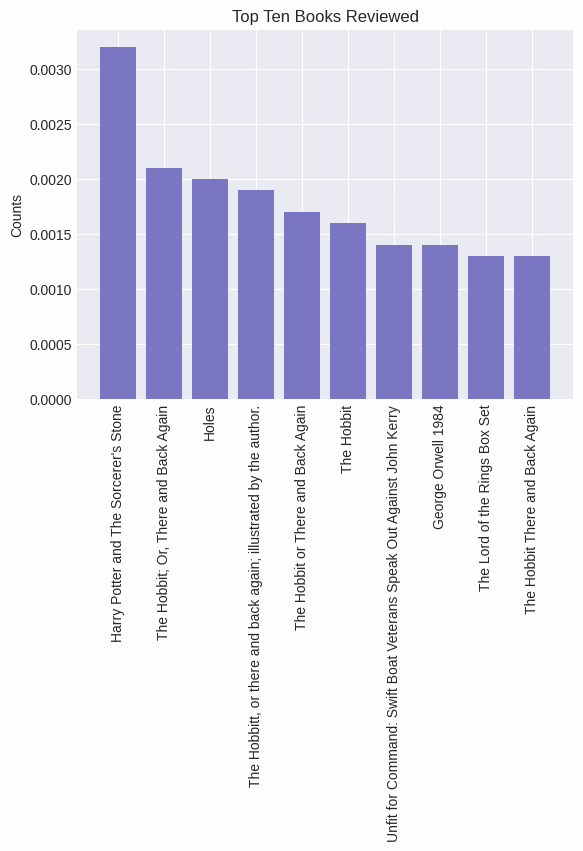

In [ ]:
# Create a Pandas Series and calculate the value counts
value_counts_series = modeling_df["Title"].value_counts(normalize=True)

# Get the top ten values
top_ten = value_counts_series.head(10)

# Plot the top ten values
plt.bar(top_ten.index, top_ten.values)
plt.ylabel('Counts')
plt.xticks(rotation=90)
plt.title('Top Ten Books Reviewed')
plt.show()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
modeling_df['clean_review'] = modeling_df['review'].apply(lambda i: clean_text(i))

In [ ]:
modeling_df.head(1)

,Id,Title,User_id,profileName,review_score,review_summary,review,authors,publishedDate,categories,clean_review
2476676,096406054X,Mouse Tales: A Behind-the-Ears Look at Disneyl...,A89Y6WZKEP069,Jewelz- Theo's Mom,2,Caution: You may lose a bit of the magic....,This is a very well written book about the inn...,David Koenig,2005.0,Biography & Autobiography,well written book inner working secret disneyl...


In [ ]:
modeling_df['clean_review'] = modeling_df['review'].apply(lambda i: clean_text(i))

#export tokenized df, this will be the new working df
modeling_df.to_csv('tokenized_data.csv')
!cp tokenized_data.csv "/content/drive/My Drive/"

## Choosing Between Models - LogReg, KNN, Decision Tree

In [ ]:
# log reg model
logreg_tfidf_small_sample = LogisticRegression(C = 0.1)
logreg_tfidf_small_sample.fit(X_train_transformed_tfidf, y_train)

# Training and test score
print(f"Train score: {logreg_tfidf_small_sample.score(X_train_transformed_tfidf, y_train)}")
print(f"Val score: {logreg_tfidf_small_sample.score(X_val_transformed_tfidf, y_val)}")

Train score: 0.6496567164179105
Test score: 0.647869696969697


For very little parameter tuning, this isn't so bad! With a .650-.648 train-test score, I can see that overfitting is not an issue as well. However, I am sure this can be improved further, next, I will get baseline scores for two other model types: KNN & Decision Trees.

In [14]:
# log reg model
logreg_tfidf_small_sample = LogisticRegression(C = 0.1)
logreg_tfidf_small_sample.fit(X_train_transformed_tfidf, y_train)

# Training and test score
print(f"Train score: {logreg_tfidf_small_sample.score(X_train_transformed_tfidf, y_train)}")
print(f"Val score: {logreg_tfidf_small_sample.score(X_val_transformed_tfidf, y_val)}")

Train score: 0.6063965884861408
Test score: 0.5990909090909091


In [21]:
pickle.dump(logreg_tfidf_small_sample,open('/content/drive/My Drive/Brainstation/models/log_reg_small_model', 'wb'))

In [28]:
# tsting to see if it loads
loaded_logreg_model = pickle.load(open('/content/drive/My Drive/Brainstation/models/log_reg_small_model', 'rb'))
y_pred = loaded_logreg_model.predict(X_test_transformed_tfidf)

In [38]:
#fit KNN model
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train_transformed_tfidf, y_train)
print(f'KNN train: {knn.score(X_train_transformed_tfidf, y_train)}')
print(f'KNN val: {knn.score(X_val_transformed_tfidf, y_val)}')
pickle.dump(knn,open('/content/drive/My Drive/Brainstation/models/knn_base_model', 'wb'))

KNN train: 0.6077825159914713
KNN test: 0.5995454545454545


I was worried there would be overfitting or lower results. Since KNNs are distance-based and this dataset is a combination of unbalanced data with no scaling, I was sure the results would be worse. You can't run a STandardScaler on a sparse matrix, so this is something to look into further.

In [37]:
#Fit decision tree
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(X_train_transformed_tfidf, y_train)
pickle.dump(dt,open('/content/drive/My Drive/Brainstation/models/decisiontree_base_model', 'wb'))

print(f'DT train: {dt.score(X_train_transformed_tfidf, y_train)}')
print(f'DT val:{dt.score(X_val_transformed_tfidf, y_val)}')

DT train: 0.6559701492537313
DT test:0.5921212121212122


There is a bit of overfitting here, but not much in comparison to my KNN base model.

Surprisingly, the base model scores for all three models (LogReg, KNN, DecisionTrees) were around the same value of ~.6 Between the three results, DecisionTree is the one I will choose to continue with. LogReg had the lowest average score, KNNs were the most overfitted, so Decision Tree it is!

In [77]:
#Fit decision tree
dt = DecisionTreeClassifier(max_depth=100,
                            min_samples_leaf=100)
dt.fit(X_train_transformed_tfidf, y_train)
pickle.dump(dt,open('/content/drive/My Drive/Brainstation/models/decisiontree_v2_model', 'wb'))

print(f'DT train: {dt.score(X_train_transformed_tfidf, y_train)}')
print(f'DT val:{dt.score(X_val_transformed_tfidf, y_val)}')

DT train: 0.6047974413646056
DT val:0.5917910447761194


### Failed/Removed BERT Code

In [ ]:
# create function for encoding

def encode_for_bert(data, text_col): #function version
  input_ids = []
  attention_masks = []

  for sent in data[text_col]:
    # Encode the sentence using the tokenizer
    encoded_sent = tokenizer.encode_plus(
        text=sent,  # Sentence to encode
        add_special_tokens = True,  # Add [CLS] and [SEP], needed for BERT
        max_length = 500,  # Truncate longer sentences
        pad_to_max_length = True,  # Pad shorter sentences, needed
        return_attention_mask = True,  # Generate attention mask
        return_tensors='pt'  # Return PyTorch tensors
    )
    input_ids.append(encoded_sent['input_ids'])
    attention_masks.append(encoded_sent['attention_mask'])

    # create function for encoding

input_ids = []
attention_masks = []
MAX_LEN = 500
for sent in X_train['clean_review']:
  encoded_sent = tokenizer.encode_plus( # Encode the sentence using the tokenizer
      text=sent,  # Sentence to encode
      add_special_tokens = True,  # Add [CLS] and [SEP], needed for BERT
      truncation=True,
      max_length = MAX_LEN,  # Truncate longer sentences
      pad_to_max_length = True,  # Pad shorter sentences, needed
      return_attention_mask = True,  # Generate attention mask
      return_tensors='pt'  # Return PyTorch tensors
    )
input_ids.append(encoded_sent['input_ids'])
attention_masks.append(encoded_sent['attention_mask'])
# this code did not work

In [ ]:
from tensorflow.keras.layers import Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model

input_ids = Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(None,), dtype=tf.int32, name='attention_mask')
bert_output = bert_model({'input_ids': input_ids, 'attention_mask': attention_mask})[0]
embedding_layer = GlobalAveragePooling1D()(bert_output)
embedding_model = Model(inputs=[input_ids, attention_mask], outputs=embedding_layer)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

embedding_model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.CosineSimilarity(), metrics=[tf.metrics.CosineSimilarity()])

early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
embedding_model.fit(dataset.batch(32), epochs=10, callbacks=[early_stopping])

In [ ]:
#load data, and encode with tensor tokenizer
text_data = X_train.review

encoded_data = tokenizer.batch_encode_plus(text_data,
                                           add_special_tokens=True,
                                           return_attention_mask=True,
                                           return_token_type_ids=False,
                                           pad_to_max_length=True
                                           )
  # from code source: `padding=True` will pad the examples with zeros to the size of the longest one in a batch,
    # and `truncation=True` will truncate the examples to the model's maximum context size.

# 30 secs

AttributeError: 'DataFrame' object has no attribute 'review'

In [ ]:
#combine results from class above
collate_tokenized_results(inputs):
  def
        input_ids = encoded['input_ids']
        attn_mask = encoded['attention_mask']

        return {
            'input_ids': torch.tensor(input_ids),
            'attn_mask': torch.tensor(attn_mask),
            'label': torch.tensor(label)
        }

SyntaxError: invalid syntax (<ipython-input-114-b562926cf34b>, line 2)

In [ ]:
#encode_for_bert(X_train, "clean_review")
#encode_for_bert(X_val, "clean_review")
#encode_for_bert(X_test, "clean_review")

encoded_test_dataset = X_train.map(encode_for_bert, batched=True) #can't map df?

AttributeError: 'DataFrame' object has no attribute 'map'

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Word2Vec Method
- I briefly attempted to use Word2Vec, but right away, the results were no differnt to TF-IDF, so I decided it would be better to try BERT.



---


### Sources

**For Learning and Implementing BERT Classification**<br>
[Text Classification with BERT](https://medium.com/@khang.pham.exxact/text-classification-with-bert-7afaacc5e49b), *Kang Pham*, Medium Article

[BERT Product Rating Predictor](https://github.com/csbanon/bert-product-rating-predictor/blob/master/bert-product-rating-predictor.ipynb), *csbanon*, Github Repo

[Sentiment Analysis](https://www.kaggle.com/code/ahmedmoharm/sentiment-analysis-bert-pytorch) - Bert - PyTorch , *Ahmed Tarek*, Kaggle

**Data Source**
[Amazon Books Reviews](https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews?select=Books_rating.csv) on Kaggle, provided by Mohamed Bekheet<br>
License CC0: Public Domain

![picture](https://i.imgur.com/9ELRD7G.png)